In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from pprint import pprint
import importlib
import community
import seaborn as sns
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim
import copy
import itertools
import pickle

Using Theano backend.
C:\Users\faisal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Reshape
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [4]:
importlib.reload(ut)

<module 'utils' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\utils.py'>

In [5]:
#word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

In [6]:
select_domain  = 0 #0:apnea ro 1:obesity
domain = ['apnea','obesity']
root = '../linkPrediction/'
filepath=[['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv'],
        ['dataset/obesity-all,3.csv',
         'dataset/obesity-distinct_keyword.csv']]
graphpath=root+'graphs/'+domain[select_domain]
datapath=root+'dataframes/'+domain[select_domain]
modelpath=root+'models'+domain[select_domain]
column_split=['keyword','author_name','affiliation_1','affiliation_2','country']
#time=[parent_start_year, train_start_year, test_start_year, total_test_period_in_year, total_year_in_each_iteration]
time=[2007,2008,2015,1,1,20]
df, key_list = ut.load_dataset(filepath[select_domain], column_split)

In [152]:
graphpath

'../linkPrediction/graphs/apnea'

In [153]:
#dynamic train graphs and test graph build and save in disk 
importlib.reload(gr)
time=[2007,2008,2015,1,1,20]
gr.dynamic_train_test_graph_build(df, key_list, graphpath, time)

1093
../linkPrediction/graphs/apnea\train_graph_2008.gpickle saved, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle saved, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle saved, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle saved, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle saved, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle saved, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle saved, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle saved, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle saved, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle saved, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle saved, nodes: 1093 edges: 2019


In [154]:
#load all graphs
time=[2007,2008,2015,1,1,20]
g_train, g_test, g_parent, g_train_static, g_test_static = gr.graph_load(graphpath, time)

../linkPrediction/graphs/apnea\train_graph_2008.gpickle loaded, nodes: 459 edges: 773
../linkPrediction/graphs/apnea\train_graph_2009.gpickle loaded, nodes: 470 edges: 688
../linkPrediction/graphs/apnea\train_graph_2010.gpickle loaded, nodes: 496 edges: 786
../linkPrediction/graphs/apnea\train_graph_2011.gpickle loaded, nodes: 536 edges: 977
../linkPrediction/graphs/apnea\train_graph_2012.gpickle loaded, nodes: 584 edges: 1054
../linkPrediction/graphs/apnea\train_graph_2013.gpickle loaded, nodes: 634 edges: 1280
../linkPrediction/graphs/apnea\train_graph_2014.gpickle loaded, nodes: 583 edges: 1144
../linkPrediction/graphs/apnea\test_graph_2015.gpickle loaded, nodes: 1093 edges: 2019
../linkPrediction/graphs/apnea\parent_graph_2007-2008.gpickle loaded, nodes: 388 edges: 689
../linkPrediction/graphs/apnea\train_graph_2008-2015.gpickle loaded, nodes: 1093 edges: 5142
../linkPrediction/graphs/apnea\test_graph_2015-2016.gpickle loaded, nodes: 1093 edges: 2019


In [166]:
importlib.reload(fs)
importlib.reload(cl)

freq=10
#time=[2001,2007,2015,1,1,10]
train_data, train_data_static, parent_data, test_data_static, edge_list = cl.non_edge_feature_dataframe(g_train, 
                                                                                                         g_test,
                                                                                                         g_parent,
                                                                                                         g_train_static, 
                                                                                                         g_test_static,  
                                                                                                         time, 
                                                                                                         freq)
node_feature, train_data = fs.dynamic_graph_feature_set(df, key_list, train_data, g_parent, g_train, g_train_static, time)

pos in time series: 1311 neg in time series: 11208 pos-neg ratio: 0.11697002141327623 total: 12519


In [167]:
#save train_data and node feature
filename= domain[select_domain]+"-train_data_"+str(time[1])+"-"+str(time[2])+".pkl"
filename_path = os.path.join(datapath,filename)
with open(filename_path,"wb") as f:
    pickle.dump(train_data,f)
    
filename= domain[select_domain]+"-node_feature_"+str(time[1])+"-"+str(time[2])+".pkl"
filename_path = os.path.join(datapath,filename)
with open(filename_path,"wb") as f:
    pickle.dump(node_feature,f)

In [174]:
# ###Extract from file
filename= domain[select_domain]+"-train_data_"+str(time[1])+"-"+str(time[2])+".pkl"
filename_path = os.path.join(datapath,filename)
with open(filename_path,"rb") as f:
    train_data = pickle.load(f)
    
filename= domain[select_domain]+"-node_feature_"+str(time[1])+"-"+str(time[2])+".pkl"
filename_path = os.path.join(datapath,filename)
with open(filename_path,"rb") as f:
    node_feature = pickle.load(f)

In [176]:
importlib.reload(fs)
importlib.reload(cl)

ts = time[1]
te = time[2]

row = train_data[ts].columns.values.tolist()
feature_names = row[2:len(row)]
all_combinations = itertools.chain(*[itertools.combinations(feature_names, i + 1)
                                     for i, _ in enumerate(feature_names)])
feature_list = list(all_combinations)
selective_features =  set(['typeaut','typeart','typenode','y_weight1','res_aloc','cm','close','pref'])
domain_info =  domain[select_domain]+"-"+str(ts)+"-"+str(te)+"-"
models  = []
results = []
con = [20,64]
batch_size = con[1]
for feature in feature_list:
    columns_drop = list(set(feature_names).difference(set(feature)))
    if len(feature)==1 and feature[0] in selective_features:
        model_name = '+'.join(feature)
        model_name = domain_info+model_name
        pruned_data = copy.deepcopy(train_data)
        pruned_data = fs.drop_feature_columns(pruned_data, columns_drop, time)
        #data reshape for classification model
        X,y, data_len_dm = cl.reshape_feature_data_for_classification(pruned_data, edge_list, time)
        #training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        model = cl.classification_model(X_train, X_test, y_train, y_test, data_len_dm, con, model_name)
        results.append(cl.model_evaluate(model, X_test, y_test, batch_size, model_name))
        #model save
        model_file_path = os.path.join(modelpath, model_name + ".h5")
        model.save(model_file_path)
        models.append(model_name)
        print(model_file_path)
        #x data save
        data_file_path = os.path.join(datapath,model_name+"-X"+".pkl")
        with open(data_file_path,"wb") as f:
            pickle.dump(X,f)
        print(data_file_path)
        #y data save
        data_file_path = os.path.join(datapath,model_name+"-y"+".pkl")
        with open(data_file_path,"wb") as f:
            pickle.dump(y,f)
        print(data_file_path)

X shape: (12519, 7, 1) y shape: (12519,)
Train on 8763 samples, validate on 3756 samples
Epoch 1/20
8763/8763 [==============================] - 1s 84us/step - loss: 0.5687 - acc: 0.7626 - val_loss: 0.4088 - val_acc: 0.8951
Epoch 2/20
8763/8763 [==============================] - 1s 114us/step - loss: 0.3795 - acc: 0.8793 - val_loss: 0.3377 - val_acc: 0.8951
Epoch 3/20
8763/8763 [==============================] - 1s 98us/step - loss: 0.3432 - acc: 0.8858 - val_loss: 0.3320 - val_acc: 0.8951
Epoch 4/20
8763/8763 [==============================] - 1s 94us/step - loss: 0.3346 - acc: 0.8914 - val_loss: 0.3246 - val_acc: 0.8951
Epoch 5/20
8763/8763 [==============================] - 1s 112us/step - loss: 0.3294 - acc: 0.8914 - val_loss: 0.3252 - val_acc: 0.8951
Epoch 6/20
8763/8763 [==============================] - 1s 104us/step - loss: 0.3262 - acc: 0.8914 - val_loss: 0.3175 - val_acc: 0.8951
Epoch 7/20
8763/8763 [==============================] - 1s 86us/step - loss: 0.3245 - acc: 0.8951 

8763/8763 [==============================] - 1s 73us/step - loss: 0.3055 - acc: 0.8971 - val_loss: 0.3122 - val_acc: 0.8970
Epoch 17/20
8763/8763 [==============================] - 1s 73us/step - loss: 0.3059 - acc: 0.8948 - val_loss: 0.2986 - val_acc: 0.8954
Epoch 18/20
8763/8763 [==============================] - 1s 70us/step - loss: 0.3031 - acc: 0.8964 - val_loss: 0.3014 - val_acc: 0.8978
Epoch 19/20
8763/8763 [==============================] - 1s 72us/step - loss: 0.3037 - acc: 0.8972 - val_loss: 0.3053 - val_acc: 0.8972
Epoch 20/20
3756/3756 [==============================] - 0s 22us/step
../linkPrediction/models\apnea-2008-2015-typeaut.h5
../linkPrediction/dataframes/apnea\apnea-2008-2015-typeaut-X.pkl
../linkPrediction/dataframes/apnea\apnea-2008-2015-typeaut-y.pkl
X shape: (12519, 7, 1) y shape: (12519,)
Train on 8763 samples, validate on 3756 samples
Epoch 1/20
8763/8763 [==============================] - 1s 79us/step - loss: 0.5075 - acc: 0.8341 - val_loss: 0.3784 - val_acc:

In [181]:
name = domain[select_domain]+"-results_"+str(time[1])+"-"+str(time[2])+".pkl"
result_path = os.path.join(datapath,name)
###save results
with open(result_path,"wb") as f:
    pickle.dump(results,f)
print(result_path)
###load reslults
with open(result_path,"rb") as f:
    results_apnea = pickle.load(f)
print(result_path)

../linkPrediction/dataframes/apnea\apnea-results_2008-2015.pkl
../linkPrediction/dataframes/apnea\apnea-results_2008-2015.pkl


In [118]:
#training from loaded data
selective_features =  set(['typeaut','typeart','typenode','y_weight1','res_aloc','cm','close','pref'])
domain_info =  domain[select_domain]+"-"+str(ts)+"-"+str(te)+"-"
for feature in selective_features:
    model_name = '+'.join(feature)
    model_name = domain_info+model_name
    X_file_path = os.path.join(datapath,model_name+"-X"+".pkl")
    with open(X_file_path,"rb") as f:
        X = pickle.load(f)
    y_file_path = os.path.join(datapath,model_name+"-y"+".pkl")
    with open(y_file_path,"rb") as f:
        y = pickle.load(f)
# ###Extract from file
# with open("myfile.pkl","rb") as f:
#     x_temp = pickle.load(f)

In [7]:
#apnea result
domain_id =0 
resultpath=root+'dataframes/'+domain[domain_id]
name = domain[domain_id]+"-results_"+str(time[1])+"-"+str(time[2])+".pkl"
result_path = os.path.join(resultpath,name)
with open(result_path,"rb") as f:
    results_apnea = pickle.load(f)
print(result_path)
#obesity result
domain_id =1 
resultpath=root+'dataframes/'+domain[domain_id]
name = domain[domain_id]+"-results_"+str(time[1])+"-"+str(time[2])+".pkl"
result_path = os.path.join(resultpath,name)
with open(result_path,"rb") as f:
    results_obesity = pickle.load(f)
print(result_path)

../linkPrediction/dataframes/apnea\apnea-results_2008-2015.pkl
../linkPrediction/dataframes/obesity\obesity-results_2008-2015.pkl


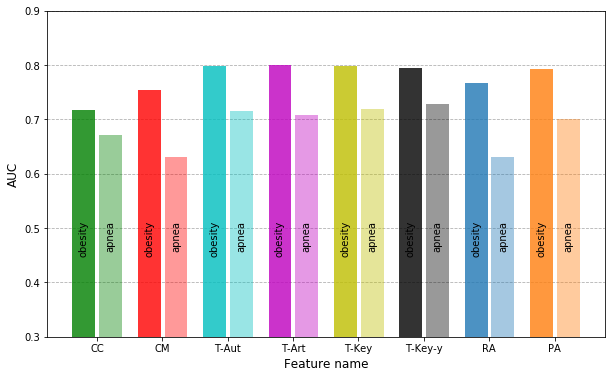

In [16]:
names = {'typeaut':'T-Aut',
         'typeart':'T-Art','typenode':'T-Key','y_weight1':'T-Key-y','res_aloc':'RA','cm':'CM','close':'CC','pref':'PA'}
colors = ['g','r','c','m','y','k','C0','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
xtick=[]
fig, ax = plt.subplots(figsize=(10,6)) 
#fig = plt.figure(figsize=(10,6))
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle='--')
plt.ylim(.3, .9)
bar_width = 0.35
result_lat = {'apnea':{},'obesity':{}}
for i in range(len(results_apnea)):
    name = results_apnea[i]['model name'].split('-')[3]
    result_lat['apnea'][names[name]]=results_apnea[i]['auc']
    result_lat['obesity'][names[name]]=results_obesity[i]['auc']
    ax.bar(i,results_obesity[i]['auc'] ,bar_width,align='center',alpha=0.8,color = colors[i])
    ax.text(i, .5,'obesity', color='k',horizontalalignment='center',rotation=90)
    ax.bar(i+bar_width+.06,results_apnea[i]['auc'] ,bar_width,align='center', alpha=0.4,color = colors[i])
    ax.text(i+bar_width+.06, .5, 'apnea', color='k',horizontalalignment='center',rotation=90)
    xtick.append(names[name])
x_pos = np.arange(len(xtick))
plt.xticks(x_pos+.2, xtick, rotation=0)
plt.xlabel('Feature name', fontsize=12)
plt.ylabel('AUC', fontsize=12)
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'auc'+ ".png")
plt.savefig(fig_file_name)
###show
plt.show()

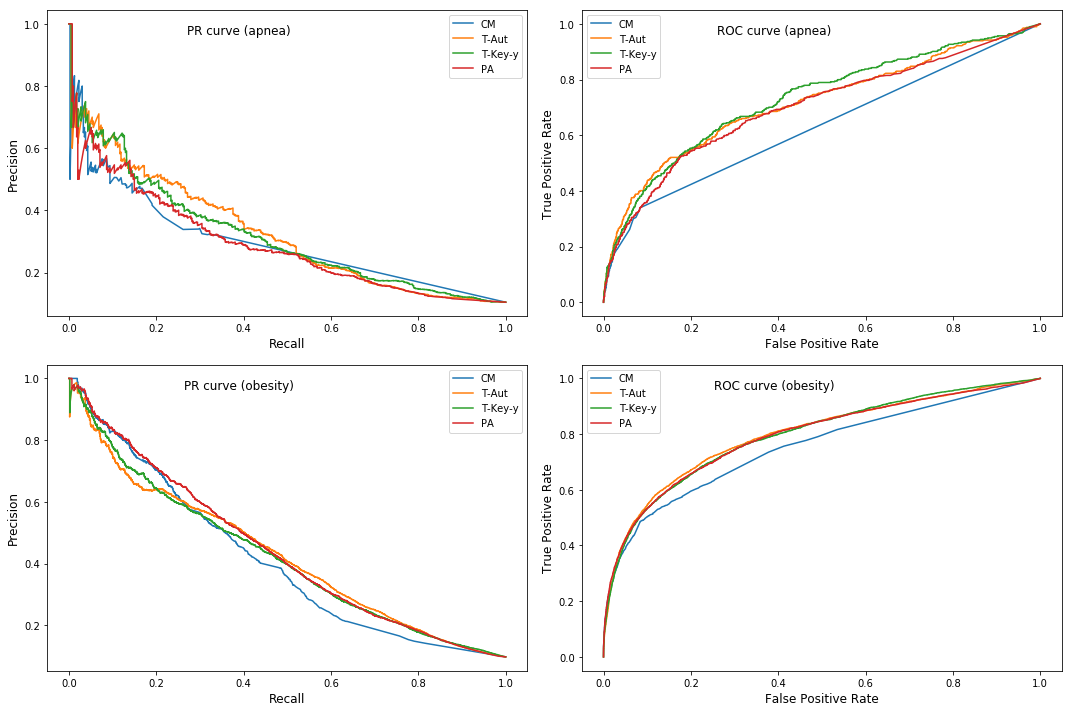

In [495]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
for i,row in enumerate(results_apnea):
    if i==1 or i==2 or i==5 or i==7:
        name = row['model name'].split('-')[3]
        plt.plot(row['recall'],row['precision'],label = names[name])
plt.legend(loc='best')
plt.title("PR curve (apnea)", position=(0.4, 0.9),fontsize=12)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.tight_layout()
plt.subplot(2,2,2)
for i,row in enumerate(results_apnea):
    if i==1 or i==2 or i==5 or i==7:
        name = row['model name'].split('-')[3]
        plt.plot(row['false positive'],row['true positive'],label = names[name])
plt.legend(loc='best')
plt.title("ROC curve (apnea)", position=(0.4, 0.9),fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.tight_layout()

plt.subplot(2,2,3)
for i,row in enumerate(results_obesity):
    if i==1 or i==2 or i==5 or i==7:
        name = row['model name'].split('-')[2]
        plt.plot(row['recall'],row['precision'],label = names[name])
plt.legend(loc='best')
plt.title("PR curve (obesity)", position=(0.4, 0.9),fontsize=12)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.tight_layout()
plt.subplot(2,2,4)
for i,row in enumerate(results_obesity):
    if i==1 or i==2 or i==5 or i==7:
        name = row['model name'].split('-')[2]
        plt.plot(row['false positive'],row['true positive'],label = names[name])
plt.legend(loc='best')
plt.title("ROC curve (obesity)", position=(0.4, 0.9),fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.tight_layout()
###save
figpath=root+'dataframes/'
fig_file_name = os.path.join(figpath,'pr-roc'+ ".png")
plt.savefig(fig_file_name)
#show
plt.show()

In [17]:
result_lat

{'apnea': {'CC': 0.670978569077507,
  'CM': 0.6310303723007517,
  'T-Aut': 0.7155084295364433,
  'T-Art': 0.7087808803679221,
  'T-Key': 0.7183707425782937,
  'T-Key-y': 0.7291126263373566,
  'RA': 0.6315761859178577,
  'PA': 0.7008220421129555},
 'obesity': {'CC': 0.7175125019217716,
  'CM': 0.7538886106870882,
  'T-Aut': 0.797863500860664,
  'T-Art': 0.8002849363198428,
  'T-Key': 0.7982936501691694,
  'T-Key-y': 0.7952978004128609,
  'RA': 0.7676728607279769,
  'PA': 0.7932854501319488}}

In [18]:
result_df = pd.DataFrame(result_lat)

In [19]:
result_df

,apnea,obesity
CC,0.670979,0.717513
CM,0.631030,0.753889
PA,0.700822,0.793285
RA,0.631576,0.767673
T-Art,0.708781,0.800285
T-Aut,0.715508,0.797864
T-Key,0.718371,0.798294
T-Key-y,0.729113,0.795298


In [20]:
print(result_df.to_latex(float_format=lambda x: '%.2f' % x))

\begin{tabular}{lrr}
\toprule
{} &  apnea &  obesity \\
\midrule
CC      &   0.67 &     0.72 \\
CM      &   0.63 &     0.75 \\
PA      &   0.70 &     0.79 \\
RA      &   0.63 &     0.77 \\
T-Art   &   0.71 &     0.80 \\
T-Aut   &   0.72 &     0.80 \\
T-Key   &   0.72 &     0.80 \\
T-Key-y &   0.73 &     0.80 \\
\bottomrule
\end{tabular}

